In [1]:
import pandas as pd
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv("./train.csv")

### Veo el score de todos los features que me permite usar el modelo sin modificar nada

In [3]:
#df['agregados']= df['escuelascercanas']+df['gimnasio']+df['centroscomercialescercanos']+df['piscina']+df['usosmultiples']
train = df.drop(['descripcion','titulo','tipodepropiedad','provincia','ciudad','direccion'],1)
train['fecha'] = pd.to_datetime(train['fecha']).dt.year
X = train.drop(['precio'],1)
y = train['precio']

from sklearn.model_selection import train_test_split
#Separo los datos de "train" en entrenamiento y prueba para probar los algoritmos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


In [4]:
#Armo modelo

xgb_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eval_metric='mae',
             gamma=0.015, importance_type='gain', learning_rate=0.026,
             max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
             n_estimators=1350, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.733, verbosity=1)


#Fitteo
xgb_model.fit(X_train, y_train)
prediccion = xgb_model.predict(X_test)
prediccion_anido = (prediccion + prediccion)/2

/home/belu/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:49:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0, 0.5, 'Score')

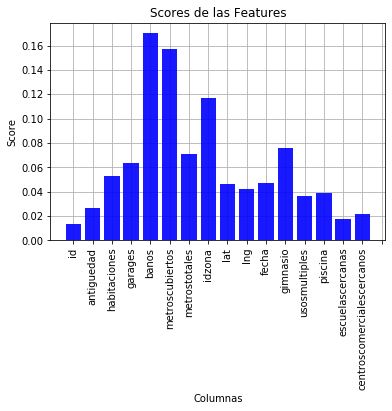

In [5]:
columnas = X_train.columns
k_utilizado = np.arange(17)
scores = xgb_model.feature_importances_
plt.grid()
plt.xticks(k_utilizado, columnas, rotation=90)
plt.bar(columnas, scores, color = 'blue', align='center', alpha=0.9, zorder =3)
plt.title("Scores de las Features")
plt.xlabel("Columnas")
plt.ylabel("Score")

In [6]:
xgb_model.feature_importances_

array([0.01376577, 0.02669996, 0.05314345, 0.06365664, 0.17003728,
       0.157168  , 0.07124492, 0.1171469 , 0.04639006, 0.04222646,
       0.04686645, 0.07615231, 0.03686172, 0.03870761, 0.01794345,
       0.02198898], dtype=float32)

In [7]:
print('MAE: ', metrics.mean_absolute_error(y_test, prediccion))

MAE:  576759.5841271565


#### Podemos observar si obtenemos un mejor score con agregados que teniendo piscina, escuelas cercanas, usos multiples y
#### centros comerciales por separado, vamos a probar unificando esos features

In [8]:
df1=df
df1['agregados']= df['escuelascercanas']+df['gimnasio']+df['centroscomercialescercanos']+df['piscina']+df['usosmultiples']
train = df1.drop(['descripcion','titulo','tipodepropiedad','provincia','ciudad','direccion','escuelascercanas','gimnasio','centroscomercialescercanos','piscina','usosmultiples'],1)
train['fecha'] = pd.to_datetime(train['fecha']).dt.year
X = train.drop(['precio'],1)
y = train['precio']

from sklearn.model_selection import train_test_split
#Separo los datos de "train" en entrenamiento y prueba para probar los algoritmos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

#Armo modelo

xgb_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eval_metric='mae',
             gamma=0.015, importance_type='gain', learning_rate=0.026,
             max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
             n_estimators=1350, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.733, verbosity=1)


#Fitteo
xgb_model.fit(X_train, y_train)
prediccion = xgb_model.predict(X_test)

/home/belu/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:54:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0, 0.5, 'Score')

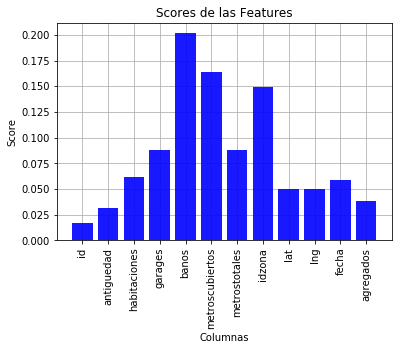

In [9]:
columnas = X_train.columns
k_utilizado = np.arange(17)
scores = xgb_model.feature_importances_
plt.grid()
plt.xticks(k_utilizado, columnas, rotation=90)
plt.bar(columnas, scores, color = 'blue', align='center', alpha=0.9, zorder =3)
plt.title("Scores de las Features")
plt.xlabel("Columnas")
plt.ylabel("Score")

In [10]:
xgb_model.feature_importances_

array([0.01667022, 0.03182724, 0.06213086, 0.08830684, 0.20148368,
       0.16426581, 0.08826561, 0.14943953, 0.04965506, 0.05037044,
       0.05880324, 0.03878142], dtype=float32)

In [11]:
print('MAE: ', metrics.mean_absolute_error(y_test, prediccion))

MAE:  578738.3332638346


# Funciones para usar mean encoding

In [12]:
def mean_target_encoding(train, nombrefeat, nombretarget):
        
    temp = train.groupby(nombrefeat)[nombretarget].transform(np.mean) #Saco promedio
    temp = preprocessing.scale(temp) #Normalizo
    train[nombrefeat + "_mean"] = temp #Dejo en el DF
    
    return train

In [13]:
def mean_target_decoding(x_test, nombrefeat, x_train):
    
    nombrefeatmean = nombrefeat + "_mean"
    
    temp = x_train.loc[:,[nombrefeat,nombrefeatmean]]
    temp = temp.set_index(nombrefeat)
    temp = temp.drop_duplicates()
    temp = temp.T.squeeze()
    values = x_test[nombrefeat].map(temp)
    x_test[nombrefeatmean] = values 

    return x_test

# mean o features originales?

In [14]:
df2=df
df2['agregados']= df['escuelascercanas']+df['gimnasio']+df['centroscomercialescercanos']+df['piscina']+df['usosmultiples']
train = df2.drop(['descripcion','titulo','tipodepropiedad','provincia','ciudad','direccion','id'],1)
train['fecha'] = pd.to_datetime(train['fecha']).dt.year
X = train
y = train['precio']

from sklearn.model_selection import train_test_split
#Separo los datos de "train" en entrenamiento y prueba para probar los algoritmos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

X_train = mean_target_encoding(X_train, "escuelascercanas", "precio")
X_test = mean_target_decoding(X_test, "escuelascercanas", X_train)


X_train = mean_target_encoding(X_train, "gimnasio", "precio")
X_test = mean_target_decoding(X_test, "gimnasio", X_train)

X_train = mean_target_encoding(X_train, "centroscomercialescercanos", "precio")
X_test = mean_target_decoding(X_test, "centroscomercialescercanos", X_train)

X_train = mean_target_encoding(X_train, "piscina", "precio")
X_test = mean_target_decoding(X_test, "piscina", X_train)

X_train = mean_target_encoding(X_train, "usosmultiples", "precio")
X_test = mean_target_decoding(X_test, "usosmultiples", X_train)

X_train = mean_target_encoding(X_train, "fecha", "precio")
X_test = mean_target_decoding(X_test, "fecha", X_train)

X_train = mean_target_encoding(X_train, "antiguedad", "precio")
X_test = mean_target_decoding(X_test, "antiguedad", X_train)

X_train = mean_target_encoding(X_train, "habitaciones", "precio")
X_test = mean_target_decoding(X_test, "habitaciones", X_train)

X_train = mean_target_encoding(X_train, "garages", "precio")
X_test = mean_target_decoding(X_test, "garages", X_train)

X_train = mean_target_encoding(X_train, "banos", "precio")
X_test = mean_target_decoding(X_test, "banos", X_train)

X_train = mean_target_encoding(X_train, "metroscubiertos", "precio")
X_test = mean_target_decoding(X_test, "metroscubiertos", X_train)

X_train = mean_target_encoding(X_train, "metrostotales", "precio")
X_test = mean_target_decoding(X_test, "metrostotales", X_train)

X_train = mean_target_encoding(X_train, "lat", "precio")
X_test = mean_target_decoding(X_test, "lat", X_train)

X_train = mean_target_encoding(X_train, "lng", "precio")
X_test = mean_target_decoding(X_test, "lng", X_train)

X_train = mean_target_encoding(X_train, "agregados", "precio")
X_test = mean_target_decoding(X_test, "agregados", X_train)

X_train = mean_target_encoding(X_train, "idzona", "precio")
X_test = mean_target_decoding(X_test, "idzona", X_train)



X_train = X_train.drop(['precio'],1) 
X_test = X_test.drop(['precio'],1) 


#Armo modelo

xgb_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eval_metric='mae',
             gamma=0.015, importance_type='gain', learning_rate=0.026,
             max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
             n_estimators=1350, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.733, verbosity=1)


#Fitteo
xgb_model.fit(X_train, y_train)
prediccion = xgb_model.predict(X_test)

/home/belu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/belu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/belu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

/home/belu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/belu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/belu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

[21:58:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0, 0.5, 'Score')

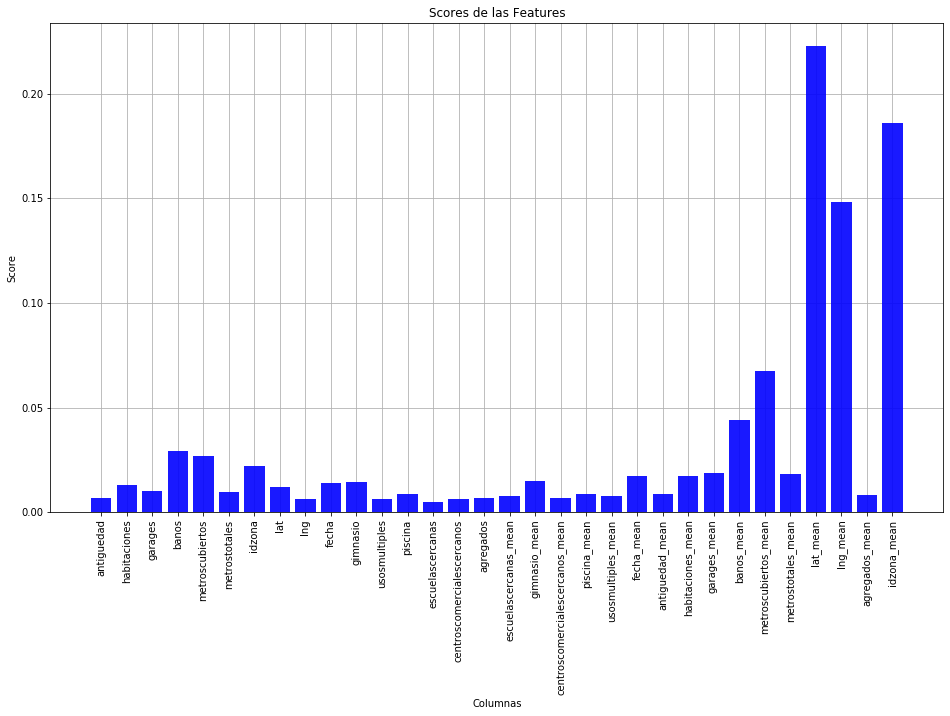

In [15]:
columnas = X_train.columns
k_utilizado = np.arange(32)
scores = xgb_model.feature_importances_
fig = plt.gcf()
fig.set_size_inches(16, 9)
plt.grid()
plt.xticks(k_utilizado, columnas, rotation=90)
plt.bar(columnas, scores, color = 'blue', align='center', alpha=0.9, zorder =3)
plt.title("Scores de las Features")
plt.xlabel("Columnas")
plt.ylabel("Score")

In [16]:
xgb_model.feature_importances_

array([0.00689047, 0.01291066, 0.01018465, 0.02938702, 0.02683402,
       0.00954526, 0.02219718, 0.01183879, 0.00636864, 0.0138018 ,
       0.01428812, 0.00628872, 0.00892114, 0.0049009 , 0.00631451,
       0.00695843, 0.00748935, 0.0151044 , 0.00690401, 0.00864687,
       0.00779386, 0.01733785, 0.00872504, 0.0171271 , 0.01879877,
       0.04417599, 0.06732691, 0.01803408, 0.22259642, 0.14817648,
       0.00816089, 0.1859716 ], dtype=float32)

In [17]:

print('MAE: ', metrics.mean_absolute_error(y_test, prediccion))

MAE:  643301.5094456584


## Agregando la direccion 

### Tiene o no direccion

In [18]:
df['direccion'].value_counts()
df1=df

In [19]:
df1.loc[df['direccion'] == 'Calle', 'direccion'] = 0
df1.loc[df['direccion'] == '1', 'direccion'] = 0
df1.loc[df['direccion'] == '.', 'direccion'] = 0
df1.loc[df['direccion'] == '-', 'direccion'] = 0
df1.loc[df['direccion'] != 0, 'direccion'] = 1

In [20]:
df1['agregados']= df['escuelascercanas']+df['gimnasio']+df['centroscomercialescercanos']+df['piscina']+df['usosmultiples']
train = df1.drop(['id','idzona','lat','descripcion','titulo','lng', 'escuelascercanas','gimnasio','centroscomercialescercanos','piscina','usosmultiples'],1)
train['fecha'] = pd.to_datetime(train['fecha']).dt.year
train.dropna()
X = train
y = train['precio']

from sklearn.model_selection import train_test_split
#Separo los datos de "train" en entrenamiento y prueba para probar los algoritmos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

X_train = mean_target_encoding(X_train, "tipodepropiedad", "precio")
X_test = mean_target_decoding(X_test, "tipodepropiedad", X_train)

X_train = mean_target_encoding(X_train, "provincia", "precio")
X_test = mean_target_decoding(X_test, "provincia", X_train)

X_train = mean_target_encoding(X_train, "ciudad", "precio")
X_test = mean_target_decoding(X_test, "ciudad", X_train)

                               
                               
X_train = X_train.drop(['precio','tipodepropiedad','provincia','ciudad'],1) 
X_test = X_test.drop(['precio','tipodepropiedad','provincia','ciudad'],1) 


#Armo modelo

xgb_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eval_metric='mae',
             gamma=0.015, importance_type='gain', learning_rate=0.026,
             max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
             n_estimators=1350, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.733, verbosity=1)


#Fitteo
xgb_model.fit(X_train, y_train)
prediccion = xgb_model.predict(X_test)


/home/belu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/belu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/belu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

[22:04:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0, 0.5, 'Score')

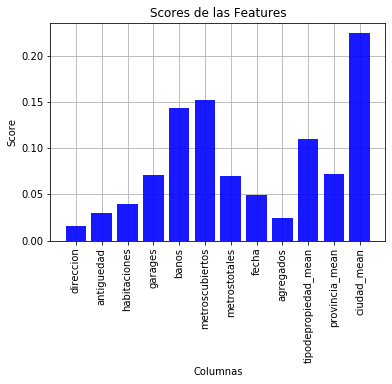

In [21]:
columnas = X_train.columns
k_utilizado = np.arange(17)
scores = xgb_model.feature_importances_
plt.grid()
plt.xticks(k_utilizado, columnas, rotation=90)
plt.bar(columnas, scores, color = 'blue', align='center', alpha=0.9, zorder =3)
plt.title("Scores de las Features")
plt.xlabel("Columnas")
plt.ylabel("Score")

In [22]:
print('MAE: ', metrics.mean_absolute_error(y_test, prediccion))

MAE:  572023.1395834655


### Pruebo usando mean encoding para direccion

In [23]:
df3=df
df3['agregados']= df['escuelascercanas']+df['gimnasio']+df['centroscomercialescercanos']+df['piscina']+df['usosmultiples']
train = df3.drop(['id','idzona','lat','descripcion','titulo','lng', 'escuelascercanas','gimnasio','centroscomercialescercanos','piscina','usosmultiples'],1)
train['fecha'] = pd.to_datetime(train['fecha']).dt.year
train.dropna()
X = train
y = train['precio']

from sklearn.model_selection import train_test_split
#Separo los datos de "train" en entrenamiento y prueba para probar los algoritmos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

#Preparo el train y test 
X_train = mean_target_encoding(X_train, "tipodepropiedad", "precio")
X_train = mean_target_encoding(X_train, "provincia", "precio")
X_train = mean_target_encoding(X_train, "ciudad", "precio")
X_train = mean_target_encoding(X_train, "direccion", "precio") # no parece ser buena idea usar esto 
                                                #no deberia tener las mismas direcciones ente train y test

X_test = mean_target_decoding(X_test, "tipodepropiedad", X_train)
X_test = mean_target_decoding(X_test, "provincia", X_train)
X_test = mean_target_decoding(X_test, "ciudad", X_train)
X_test = mean_target_decoding(X_test, "direccion", X_train)
                               
                               
X_train = X_train.drop(['precio','tipodepropiedad','provincia','ciudad','direccion'],1) 
X_test = X_test.drop(['precio','tipodepropiedad','provincia','ciudad','direccion'],1) 


#Armo modelo

xgb_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eval_metric='mae',
             gamma=0.015, importance_type='gain', learning_rate=0.026,
             max_delta_step=0, max_depth=11, min_child_weight=1, missing=None,
             n_estimators=1350, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.733, verbosity=1)


#Fitteo
xgb_model.fit(X_train, y_train)
prediccion = xgb_model.predict(X_test)

/home/belu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/belu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/belu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

[22:08:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Text(0, 0.5, 'Score')

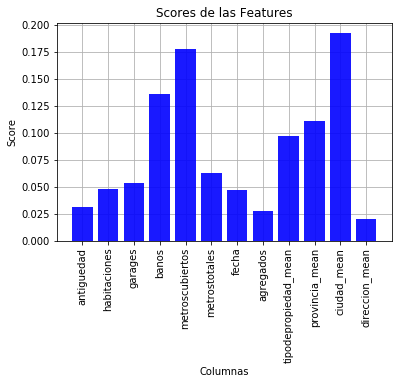

In [24]:
columnas = X_train.columns
k_utilizado = np.arange(17)
scores = xgb_model.feature_importances_
plt.grid()
plt.xticks(k_utilizado, columnas, rotation=90)
plt.bar(columnas, scores, color = 'blue', align='center', alpha=0.9, zorder =3)
plt.title("Scores de las Features")
plt.xlabel("Columnas")
plt.ylabel("Score")

In [25]:
print('MAE: ', metrics.mean_absolute_error(y_test, prediccion))

MAE:  571175.8407286021


#### La importancia de la direccion fue 0.00072118 por lo que al menos de esta forma no es relevante para el modelo . En cambio si no uso lo antes mencionado y uso direccion mean el score de direccion pasa a ser 0.0006491 mas bajo de lo que era simplemente remplanzando por 0 si no era una direccion valida y por 1 si lo era.

# Buscar palabras clave en la descripcion y titulo

In [84]:
#Ver notebook correspondiente